In [18]:
library(HarmonizR)
library(tidyverse)

library(grid)
library(gridExtra)
library(patchwork)

source("/home/yuliya/repos/other/removeBatch/evaluation_utils/plots_eda.R")
source("/home/yuliya/repos/other/removeBatch/evaluation_utils/evaluation_funcs.R")

In [2]:
# r version
R.Version()$version.string


[1] "R version 4.3.2 (2023-10-31)"

In [3]:
# harmonizR version
packageVersion("HarmonizR")

[1] ‘0.99.2’

In [19]:
cbPalette <- c("#CC79A7", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00")

# Load data

In [4]:
all_expression <- read.table("before/all_expression_UNION.tsv", header = TRUE, sep = "\t", row.names = 1)
all_metadata <- read.table("before/all_metadata.tsv", header = TRUE, sep = "\t", row.names = 1)

# for this remove GSE26712 Dataset samples
all_metadata <- all_metadata %>%
    filter(Status == "normal" | Status == "ovarian tumour" & HistSubtypes == "high-grade serous carcinoma")
all_expression <- all_expression[, rownames(all_metadata)]

print(paste0("Number of features: ", nrow(all_expression), " Number of samples: ", ncol(all_expression)))
print(paste0("Number of metadata columns: ", ncol(all_metadata), " Number of metadata samples: ", nrow(all_metadata)))


[1] "Number of features: 51276 Number of samples: 332"
[1] "Number of metadata columns: 6 Number of metadata samples: 332"


In [5]:
all_metadata <- all_metadata %>%
    mutate(Status = as.factor(Status),
           dataset = as.factor(Dataset))
all_metadata$Sample_geo_ID <- rownames(all_metadata)

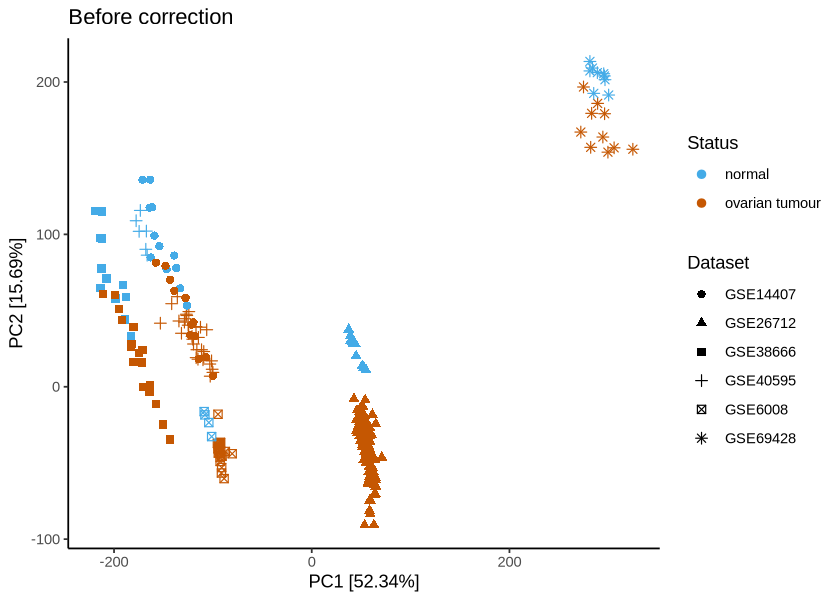

In [42]:
before_correction_pca <- pca_plot(
    na.omit(all_expression), all_metadata, 
    "Before correction",
    col_col="Status", shape_col="Dataset", 
    quantitative_col_name = 'Sample_geo_ID', cbPalette=c("#44abe7", "#c55702"))

options(repr.plot.width=7, repr.plot.height=5)
before_correction_pca

# Correction

In [7]:
design <- model.matrix(~all_metadata$Status)
colnames(design) <- c("Intercept", "HGSC")

## Using limma

In [8]:
corrected_limma <- limma::removeBatchEffect(
        all_expression, 
        batch = all_metadata$Dataset, 
        design = design) %>% 
    as.data.frame()


Warning message:
“Partial NA coefficients for 30148 probe(s)”


In [9]:
print(paste0("Number of features: ", nrow(all_expression), " Number of samples: ", ncol(all_expression)))
all_metadata %>%
    group_by(Dataset) %>% summarise(n())

[1] "Number of features: 51276 Number of samples: 332"


Dataset,n()
<chr>,<int>
GSE14407,24
GSE26712,195
GSE38666,30
GSE40595,37
GSE6008,27
GSE69428,19


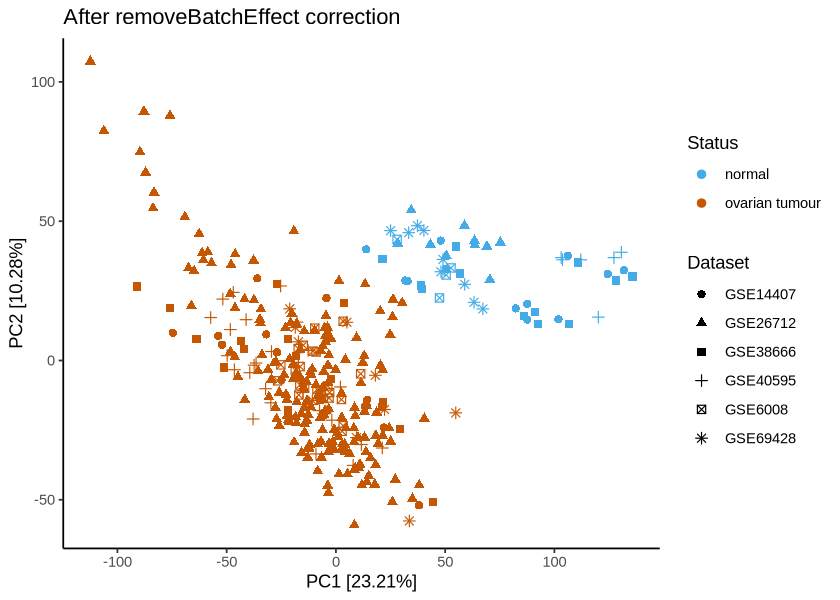

In [41]:
after_limma_pca <- pca_plot(
    na.omit(corrected_limma), all_metadata, 
    "After removeBatchEffect correction",
    col_col="Status", shape_col="Dataset", 
    quantitative_col_name = 'Sample_geo_ID', cbPalette=c("#44abe7", "#c55702"))

options(repr.plot.width=7, repr.plot.height=5)
after_limma_pca

## Using HarmonizR

In [11]:
design_hz <- all_metadata %>%
    select(Sample_geo_ID, Dataset) %>%
    mutate(batch = as.numeric(as.factor(Dataset)),
           sample = c(1:ncol(all_expression)),
           ID = Sample_geo_ID) %>%
    select(-Dataset, -Sample_geo_ID) %>%
    select(ID, sample, batch)

In [12]:
print(paste0("Number of features: ", nrow(all_expression), " Number of samples: ", ncol(all_expression)))
all_metadata %>%
    group_by(Dataset) %>% summarise(n())

[1] "Number of features: 51276 Number of samples: 332"


Dataset,n()
<chr>,<int>
GSE14407,24
GSE26712,195
GSE38666,30
GSE40595,37
GSE6008,27
GSE69428,19


In [13]:
HarmonizR::harmonizR(
    all_expression, 
    design_hz) -> harmonized

Initializing HarmonizR...

Reading the files...

Preparing...

Splitting the data using ComBat adjustment...

Rebuilding...

Writing file...

Termination.



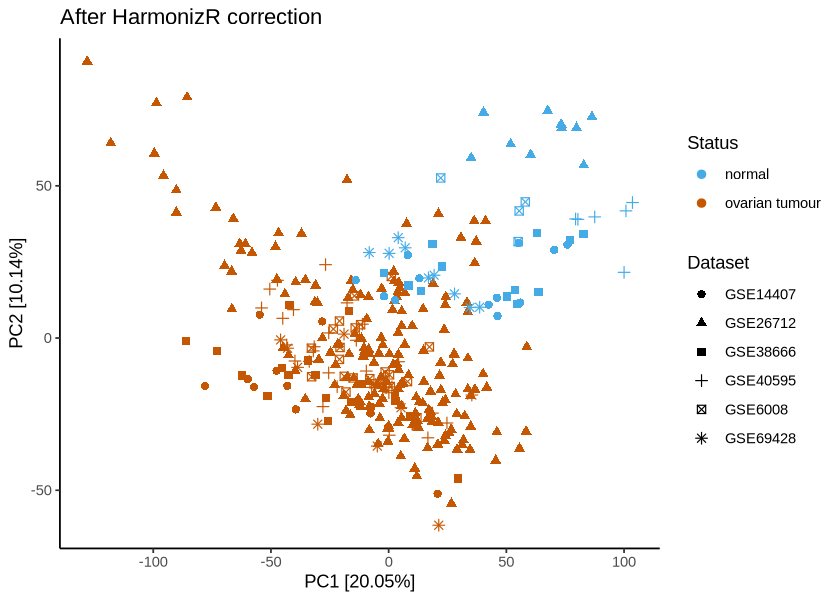

In [37]:
after_H_pca <- pca_plot(
    na.omit(harmonized), all_metadata, 
    "After HarmonizR correction",
    col_col="Status", shape_col="Dataset", 
    quantitative_col_name = 'Sample_geo_ID', cbPalette=c("#44abe7", "#c55702"))

options(repr.plot.width=7, repr.plot.height=5)
after_H_pca

##  Linear model per variable

In [15]:
library(variancePartition)

Loading required package: limma

Warning message:
“package ‘limma’ was built under R version 4.3.3”


Loading required package: BiocParallel

Warning message:
“package ‘BiocParallel’ was built under R version 4.3.3”

Attaching package: ‘variancePartition’


The following object is masked from ‘package:limma’:

    topTable




In [16]:
# version of variancePartition
packageVersion("variancePartition")

[1] ‘1.32.2’

In [26]:
form <- ~ Status + Dataset

lmpv_plot_uncorrected <- lmpv_plot(all_expression, all_metadata,
    title = paste("Before correction"), show_legend=F, form = form)

lmpv_plots_Rcorrected <- lmpv_plot(corrected_limma, all_metadata,
    title = paste("After removeBatchEffect-limma correction"), form = form, show_legend=F)
lmpv_plot_Hcorrected <- lmpv_plot(harmonized, all_metadata,
    title = paste("After HarmonizR correction"), show_legend=T, form = form)

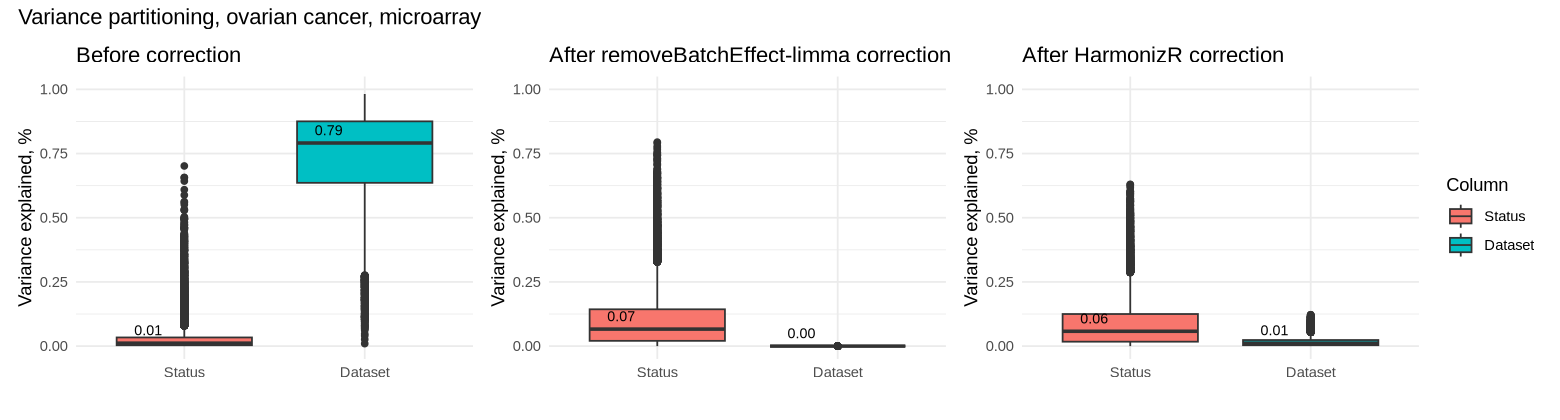

In [49]:
layout <- (lmpv_plot_uncorrected + lmpv_plots_Rcorrected + lmpv_plot_Hcorrected)
layout <- layout + plot_annotation("Variance partitioning, ovarian cancer, microarray")
options(repr.plot.width=13, repr.plot.height=3.5)
layout

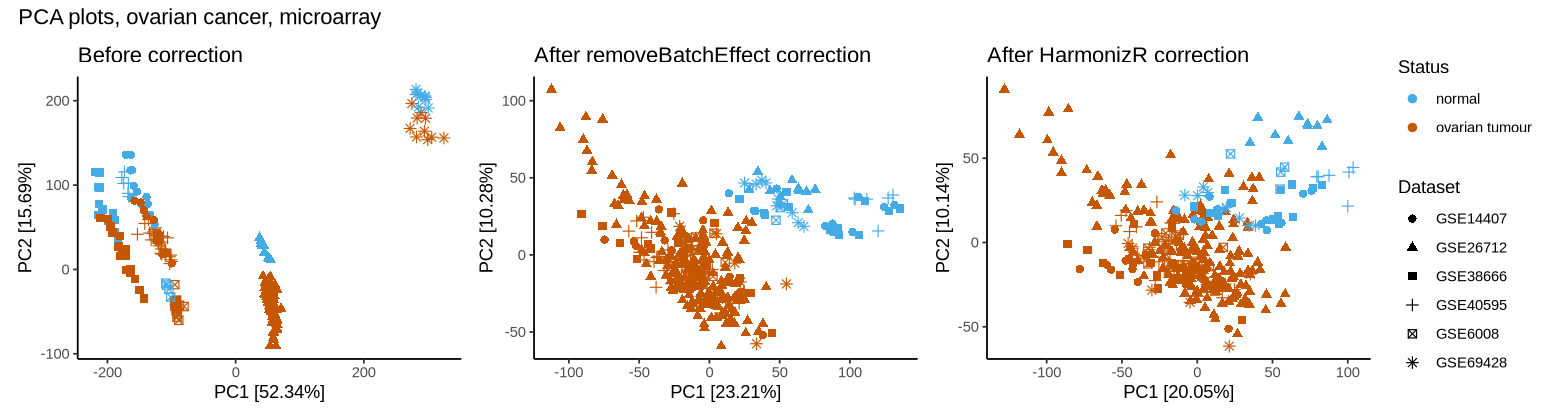

In [50]:
layout <- (before_correction_pca + theme(legend.position="none") + after_limma_pca + theme(legend.position="none") + after_H_pca)
layout <- layout + plot_annotation("PCA plots, ovarian cancer, microarray")
options(repr.plot.width=13, repr.plot.height=3.5)
layout